In [1]:
import os
import sys

sys.path.append(os.path.join(os.getcwd(), ".."))

In [2]:
from pyldl.utils import encode_one_hot, kullback_leibler_divergence, load_usps
from pyldl.encapsulations import AutoEncoder, Sequential
from pyldl.modules import Linear
from pyldl.losses import BCELoss, MSELoss, CrossEntropyLoss
from pyldl.activations import Sigmoid, Tanh, Softmax
from pyldl.optimizers import SGD

In [3]:
from itertools import product
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np

# Loading the dataset

In [4]:
np.random.seed(0)

In [5]:
X, y = load_usps("../data/USPS_data.txt")

# Min-Max Scaling
x_min = X.min()
x_max = X.max()
X = (X - x_min) / (x_max - x_min)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Network Optimization

In [6]:
params = {
    "activation_functions": [Sigmoid, Tanh],
    "batch_size": [64, 128],
    "gradient_step": [0.01, 0.001],
    "loss": [BCELoss, MSELoss],
    "n_epochs": [1000],
    "n_neurons_per_layer": [[X_train.shape[1], 64, 4], [X_train.shape[1], 100, 4], [X_train.shape[1], 32, 4]],
}

In [7]:
def grid_search(X_train, X_test, params):
    best_score = np.inf
    best_model = None
    best_params = None
    best_losses = None
    for activation, batch_size, gradient_step, loss, n_epochs, n_neurons_per_layer in product(*params.values()):
        encoder_layers, decoder_layers = [], []
        for i in range(len(n_neurons_per_layer)-1):
            encoder_layers += [Linear(n_neurons_per_layer[i], n_neurons_per_layer[i+1]), activation()]
            decoder_layers = [Linear(n_neurons_per_layer[i+1], n_neurons_per_layer[i]), activation()] + decoder_layers
        autoencoder = AutoEncoder(Sequential(*encoder_layers), Sequential(*decoder_layers))
        losses = SGD(autoencoder, loss(), X_train, X_train, batch_size=batch_size, gradient_step=gradient_step, n_iter=n_epochs)
        #reconstructed_images = autoencoder(X_test)
        #score = np.abs(kullback_leibler_divergence(X_test, reconstructed_images))
        score = losses[-1]
        if score < best_score:
            best_model = autoencoder
            best_score = score
            best_losses = losses
            best_params = {
                "activation_functions": activation.__name__,
                "batch_size": batch_size,
                "gradient_step": gradient_step,
                "loss": loss.__name__,
                "n_epochs": n_epochs,
                "n_neurons_per_layer": n_neurons_per_layer,
            }
    return best_model, best_params, best_score, best_losses

In [8]:
best_model, best_params, best_score, best_losses = grid_search(X_train, X_test, params)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [01:40<00:00,  9.91it/s]


In [9]:
print("Best parameters: ", best_params)

Best parameters:  {'activation_functions': 'Sigmoid', 'batch_size': 64, 'gradient_step': 0.01, 'loss': 'BCELoss', 'n_epochs': 1000, 'n_neurons_per_layer': [256, 100, 4]}


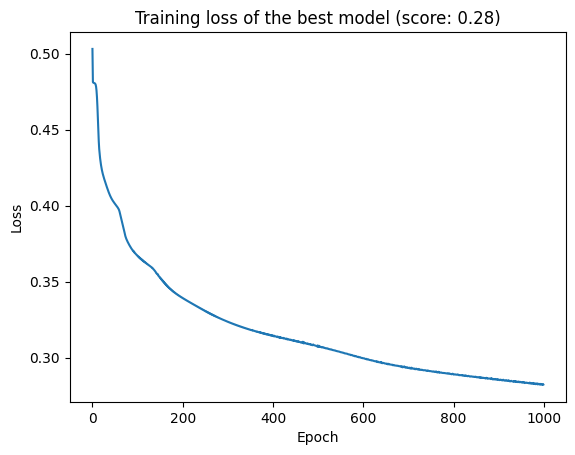

In [10]:
plt.plot(best_losses)
plt.title(f"Training loss of the best model (score: {best_score:.2f})")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [11]:
print("Compression rate ", best_params["n_neurons_per_layer"][-1] / X_train.shape[1])

Compression rate  0.015625


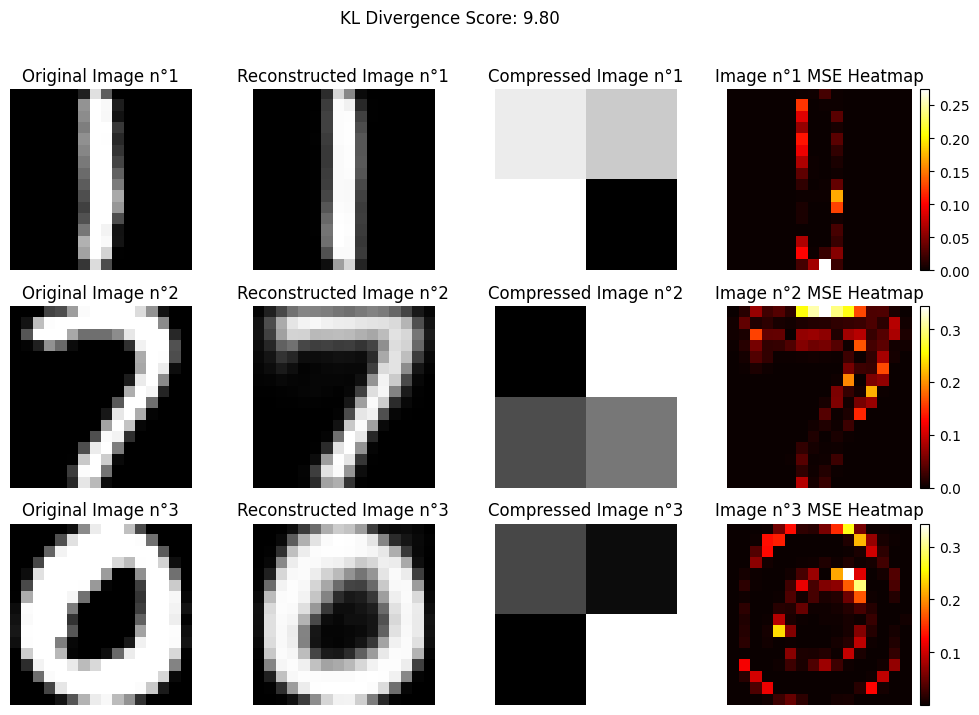

In [13]:
n_images = 3

random_indexes = np.random.choice(range(len(X_test)), n_images)
original_images = X_test[random_indexes]
compressed_images = best_model._encoder(original_images)
reconstructed_images = best_model(original_images)

plt.subplots(3, 4, figsize=(12, 8))
plt.suptitle(f"KL Divergence Score: {kullback_leibler_divergence(original_images, reconstructed_images):.2f}")

for i in range(n_images):
    plt.subplot(3, 4, 4*i+1)
    plt.imshow(original_images[i].reshape(16, 16), cmap='gray')
    plt.title(f"Original Image n°{i+1}")
    plt.axis('off')

    plt.subplot(3, 4, 4*i+2)
    plt.imshow(reconstructed_images[i].reshape(16, 16), cmap='gray')
    plt.title(f"Reconstructed Image n°{i+1}")
    plt.axis('off')

    plt.subplot(3, 4, 4*i+3)
    plt.imshow(compressed_images[i].reshape(2, 2), cmap='gray')
    plt.title(f"Compressed Image n°{i+1}")
    plt.axis('off')

    # Calculate and plot the heatmap
    mse_images = (original_images[i] - reconstructed_images[i])**2
    heatmap_data = mse_images.reshape(16, 16)
    plt.subplot(3, 4, 4*i+4)
    heatmap = plt.imshow(heatmap_data, cmap='hot', aspect='auto')
    plt.colorbar(heatmap, fraction=0.046, pad=0.04)
    plt.title(f'Image n°{i+1} MSE Heatmap')
    plt.axis('off')
    
plt.show()